Import Functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Datasets loading

In [3]:
train_data=pd.read_csv('train data.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
oil_prices=pd.read_csv('oil price.csv')
oil_prices.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [5]:
holidays=pd.read_csv('holidays.csv')
print(holidays.head())

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


Converting date to datetime

In [6]:
train_data['date'] = pd.to_datetime(train_data['date'])
oil_prices['date'] = pd.to_datetime(oil_prices['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
train_data.set_index('date', inplace=True)
oil_prices.set_index('date', inplace=True)
holidays.set_index('date', inplace=True)

Aggregating Sales

In [7]:
total_daily_sales = train_data.groupby('date')['sales'].sum()
total_daily_sales = total_daily_sales[total_daily_sales.index.drop_duplicates(keep='first')]
print("Dropped duplicate dates in sales data, if any.")
print(total_daily_sales)

Dropped duplicate dates in sales data, if any.
date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64


In [8]:
holidays['holiday']=holidays['type'].apply(lambda x:1 if x=='Holiday' else 0)

Merging oil prices and holidays

In [9]:
exog_data = pd.merge(total_daily_sales, oil_prices[['dcoilwtico']], left_index=True, right_index=True, how='left')
exog_data = pd.merge(exog_data, holidays[['holiday']], left_index=True, right_index=True, how='left')

Checking Duplicates and removing them

In [10]:
total_daily_sales = total_daily_sales[total_daily_sales.index.drop_duplicates(keep='first')]
print("Dropped duplicate dates in sales data, if any.")
exog_data=exog_data.loc[exog_data.index.drop_duplicates(keep='first')]
print("Dropped Duplicates in exog data if any")
print(exog_data)

Dropped duplicate dates in sales data, if any.
Dropped Duplicates in exog data if any
                    sales  dcoilwtico  holiday
date                                          
2013-01-01    2511.618999         NaN      1.0
2013-01-02  496092.417944       93.14      NaN
2013-01-03  361461.231124       92.97      NaN
2013-01-04  354459.677093       93.12      NaN
2013-01-05  477350.121229         NaN      0.0
...                   ...         ...      ...
2017-08-11  826373.722022       48.81      0.0
2017-08-12  792630.535079         NaN      NaN
2017-08-13  865639.677471         NaN      NaN
2017-08-14  760922.406081       47.59      NaN
2017-08-15  762661.935939       47.57      1.0

[1714 rows x 3 columns]


Checking Missing values and removing them

In [11]:
exog_data['dcoilwtico'] = exog_data['dcoilwtico'].ffill().bfill()  # Forward-fill and backward-fill missing oil prices
exog_data['holiday'] = exog_data['holiday'].fillna(0)  # Fill missing holiday values with 0 (non-holiday)

In [12]:
 # Align exog_vars
exog_vars = exog_data[['dcoilwtico', 'holiday']]
exog_vars = exog_vars.loc[~exog_vars.index.duplicated(keep='first')]
exog_vars = exog_vars.reindex(total_daily_sales.index)

Scaling data

In [13]:
#Intialize scalers
scaler_sales=MinMaxScaler()
scaler_exog=MinMaxScaler()

In [14]:
total_daily_sales_scaled = scaler_sales.fit_transform(total_daily_sales.values.reshape(-1, 1))
exog_vars_scaled = scaler_exog.fit_transform(exog_vars)

Metrics

In [15]:
#Directinality accuracy
def directionality_accuracy(actual, predicted):
    actual = actual.flatten()
    return np.mean(np.sign(np.diff(actual)) == np.sign(np.diff(predicted)))

In [26]:
#RMSE
def evaluate_rmse_with_scaled_exog(total_daily_sales_scaled, exog_vars_scaled):
    # Create ARIMA model with scaled data
    exog_vars_scaled = exog_vars_scaled[:len(total_daily_sales_scaled)]
    model = ARIMA(total_daily_sales_scaled, order=(5, 1, 5), exog=exog_vars_scaled)
    model_fit = model.fit()
     # Forecast
    forecast_steps = 183
    train_end = len(total_daily_sales_scaled) - forecast_steps
    test = total_daily_sales_scaled[train_end:]
    predictions = model_fit.predict(start=train_end, end=len(total_daily_sales_scaled)-1, exog=exog_vars_scaled[train_end:])

    # RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f"ARIMA(5,1,5) with Scaled Exogenous Variables - RMSE: {rmse}")

    # Directional Accuracy
    direction_acc = directionality_accuracy(test, predictions)
    print(f"ARIMA(5,1,5) Directionality Accuracy: {direction_acc * 100:.2f}%")

    return rmse, direction_acc, test, predictions, model_fit

# Evaluation
rmse, direction_acc, test, predictions, model_fit = evaluate_rmse_with_scaled_exog(total_daily_sales_scaled, exog_vars_scaled)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5,1,5) with Scaled Exogenous Variables - RMSE: 0.07218639646770421
ARIMA(5,1,5) Directionality Accuracy: 78.57%


Forecasting

In [27]:
forecast_steps = 150
future_exog_vars = exog_vars_scaled[-forecast_steps:]  # Use the last known exogenous variables for forecasting
forecast = model_fit.forecast(steps=forecast_steps, exog=future_exog_vars)
forecast_index = pd.date_range(start=len(total_daily_sales_scaled), periods=forecast_steps, freq='D')
test_index = pd.date_range(start=len(total_daily_sales_scaled) - len(test), periods=len(test), freq='D')


Plotting

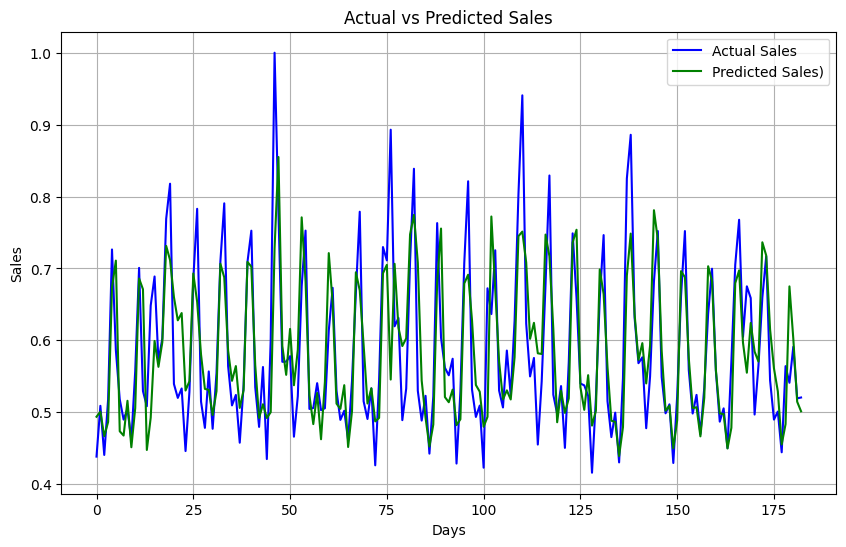

In [28]:
#plotting actual sales
plt.figure(figsize=(10, 6))
plt.plot(range(len(test)), test, label='Actual Sales', color='blue')
plt.plot(range(len(predictions)), predictions, label='Predicted Sales)', color='green')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

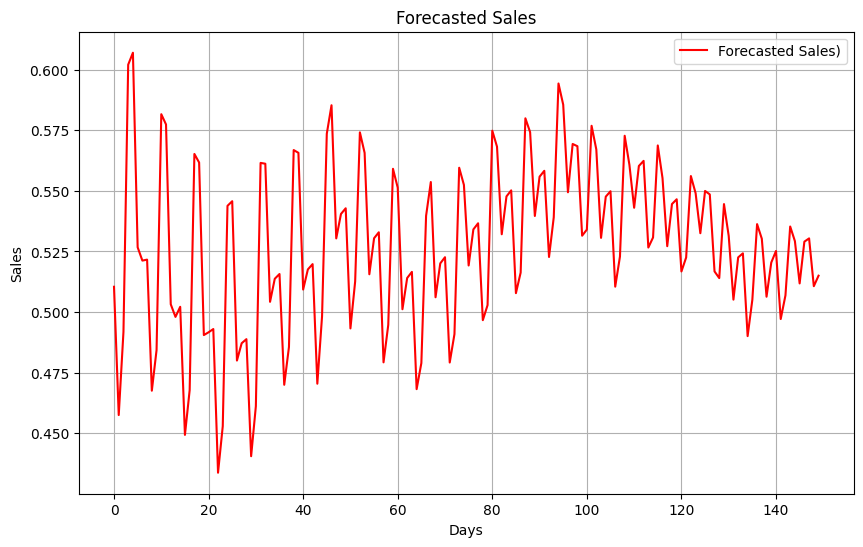

In [29]:
# plotting forecast sales
plt.figure(figsize=(10, 6))
plt.plot( forecast, label='Forecasted Sales)', color='red')
plt.title('Forecasted Sales')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print(forecast)

[0.51043964 0.45752994 0.49184272 0.60203818 0.60695789 0.52671748
 0.52123096 0.52162901 0.46757826 0.48433247 0.58160907 0.57737259
 0.50322545 0.49800736 0.50217869 0.44935453 0.46780912 0.56521258
 0.5616802  0.4905174  0.49166609 0.49300225 0.43375072 0.45294846
 0.54381211 0.54572419 0.48001752 0.48714801 0.48883423 0.44055997
 0.46118638 0.56152293 0.56117903 0.50423271 0.51373515 0.51570174
 0.47001337 0.485598   0.56681566 0.5656721  0.50929686 0.51759535
 0.51977937 0.47045666 0.49830245 0.57353724 0.58529557 0.53038658
 0.54046031 0.54280517 0.49326073 0.51263705 0.57411258 0.56566697
 0.51559171 0.53044803 0.53290315 0.47926647 0.4947158  0.55908341
 0.55132665 0.50117    0.51405574 0.51657612 0.46821837 0.47897576
 0.53969374 0.5536344  0.50611221 0.52008376 0.52262962 0.47920284
 0.49091298 0.55951937 0.55244583 0.51921486 0.53408778 0.53662418
 0.49665519 0.5028617  0.57480276 0.56820665 0.53209026 0.54769942
 0.5501959  0.50780404 0.51628799 0.57991602 0.57420966 0.5396

Output

In [21]:
output_data = pd.DataFrame({
    'Date': test_index.append(forecast_index),  # Append the test and forecast date ranges
    'Actual Sales': list(test) + [None] * forecast_steps,  # Actual sales for the test period
    'Predicted Sales': list(predictions) + [None] * forecast_steps,  # Predicted sales for the test period
    'Forecasted Sales': [None] * len(test) + list(forecast)  # Forecasted sales for the future period
})

In [22]:
output_data.to_csv('sales_predictions.csv', index=False)
print("CSV file saved as 'sales_predictions.csv'")

CSV file saved as 'sales_predictions.csv'


In [88]:
#For colab
#from google.colab import files
#files.download('sales_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

.h5 File

In [32]:
#import joblib
#from google.colab import files
#output_data.to_hdf('sales_predictions.h5',key='df',mode='w')
#files.download('sales_predictions.h5')

<ipython-input-32-eb3cb1c0118f>:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['Actual Sales'], dtype='object')]

  output_data.to_hdf('sales_predictions.h5',key='df',mode='w')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
#joblib.dump(model_fit, 'arima_model.pkl')
#files.download('arima_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>